Trabajo Practico 2

In [1]:
# LIBRERIAS
import numpy as np
from PIL import Image, ImageOps
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

1. Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.
a) Verifique si la red aprendió las imágenes enseñadas.
b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.
c) Evalúe la existencia de estados espurios en la red: patrones inversos y
combinaciones de un número impar de patrones. (Ver Spurious States, en la sección
2.2, Hertz, Krogh & Palmer, pág. 24).
d) Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de
aprender todas las imágenes? Explique.

In [2]:
# FUNCIONES

# Para pasar de patron a BMP
def patternToBMPImage(S, width, height):
    if len(S) > width * height:
        S = S[:width * height]
    imgArray = np.reshape(S, (height, width))  # Ajustar a (alto, ancho)
    imgArray = imgArray + np.ones((height, width))
    imgArray = (imgArray * 127.5).astype(np.uint8)  # Convertir de 0/1 a 0/255

    return Image.fromarray(imgArray)

# Para mostrar el progreso de la imagen adaptandose 
def showImageProgress(input, height, width, t):
    currentImg = patternToBMPImage(input, width, height)
    display(currentImg)
    time.sleep(t * 1e-3)
    clear_output(wait=True)

# Para hacer update sync
def hopfieldUpdateSync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState

    return hasUpdated

# Hopfield sync
def hopfieldSync(weights, input, height=0, width=0, show=False, t=1):
    N = height * width
    updates = 0
    max_iterations = len(input) * 10  # Evitar bucles infinitos

    for iteration in range(max_iterations):
        current_updates = 0
        for i in range(len(input)):
            update = hopfieldUpdateSync(weights, input, i)
            current_updates += update
            if update and show and N != 0:
                showImageProgress(input, height, width, t)
        
        updates += current_updates
        if current_updates == 0:
            break  # Si no hubo actualizaciones, salimos del bucle
    
    if show and updates > 0:
        time.sleep(1.5)

    return updates

# Para hacer update unsync
def hopfieldUpdateUnsync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState
    
    return hasUpdated

# Hopfield sync - REVISAR
def hopfieldUnsync(weights, input, height=0, width=0, show=False, t=1):
    length = len(input)
    N = height * width
    updates = 0
    randomUpdateIndexes = np.random.permutation(length)

    for i in range(length):
        update = hopfieldUpdateUnsync(weights, input, randomUpdateIndexes[i])
        updates += update
        if update and show and N != 0:
            showImageProgress(input, height, width, t)

    if show and updates > 0:
        time.sleep(1.5)

    return updates

# Carga una imagen y la combierte a un patron
def loadImageAndConvertToPattern(path):
    image = Image.open(path).convert('1')  # Convertir a unos y ceros
    vector = np.array(image).astype(int) 
    vector = vector.flatten() # Imagen como vector
    pattern =  2 * vector - 1 # Patrones de -1 o 1

    return image, pattern

# Muestra imagenes
def showImages(images):
    for img in images:
        display(img)

# Arma la matriz de pesos
def computeWeights(patterns):
    length = len(patterns[0]) # Largo de un patron
    weights = np.zeros((length, length), float)

    for pattern in patterns:
        weights += np.outer(pattern, pattern)

    return weights - len(patterns) * np.eye(length) # Elimino la diagonal para pesos de autoconexiones

Imagen original 1:


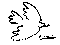

Imagen recuperada 1:


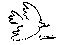

La red aprendió la imagen 1 suministrada.
Imagen original 2:


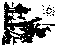

Imagen recuperada 2:


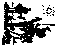

La red aprendió la imagen 2 suministrada.
Imagen original 3:


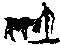

Imagen recuperada 3:


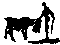

La red aprendió la imagen 3 suministrada.


In [151]:
# VERIFICACION DE APRENDIZAJE

# Imagenes 45x60
paths45x60 = ['ImgTP2/paloma.bmp', 'ImgTP2/quijote.bmp', 'ImgTP2/torero.bmp']
# Imagenes 50x50
paths50x50 = ['ImgTP2/panda.bmp', 'ImgTP2/perro.bmp', 'ImgTP2/v.bmp']

# Convertir a patron
images45x60, patterns45x60 = zip(*(loadImageAndConvertToPattern(path) for path in paths45x60))
images50x50, patterns50x50 = zip(*(loadImageAndConvertToPattern(path) for path in paths50x50))

# Selecciono las imagenes a aprender
#images = images50x50
#patterns = patterns50x50
images = images45x60
patterns = patterns45x60

[width, height] = images[0].size

weights = computeWeights(patterns)
inputs = [pattern.copy() for pattern in patterns]
sync = True

for i, input in enumerate(inputs):
    print(f"Imagen original {i+1}:")
    display(images[i])

    show = True
    updates = 0

    if sync:
        updates = hopfieldSync(weights, input, height, width, show)
    else:
        updates = hopfieldUnsync(weights, input, height, width, show)
    
    print(f"Imagen recuperada {i+1}:")
    recoveredImage = patternToBMPImage(input, width, height)
    display(recoveredImage)

    if updates == 0:
        print(f'La red aprendió la imagen {i+1} suministrada.')
        time.sleep(1)


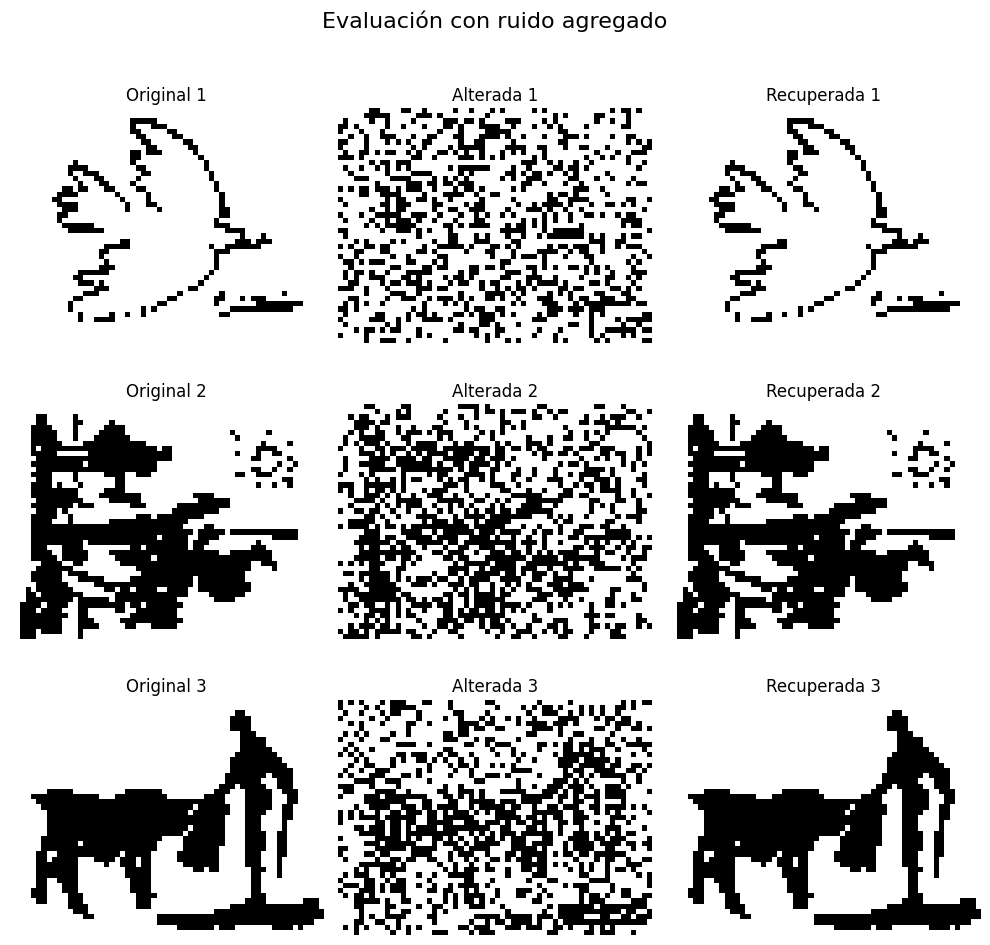

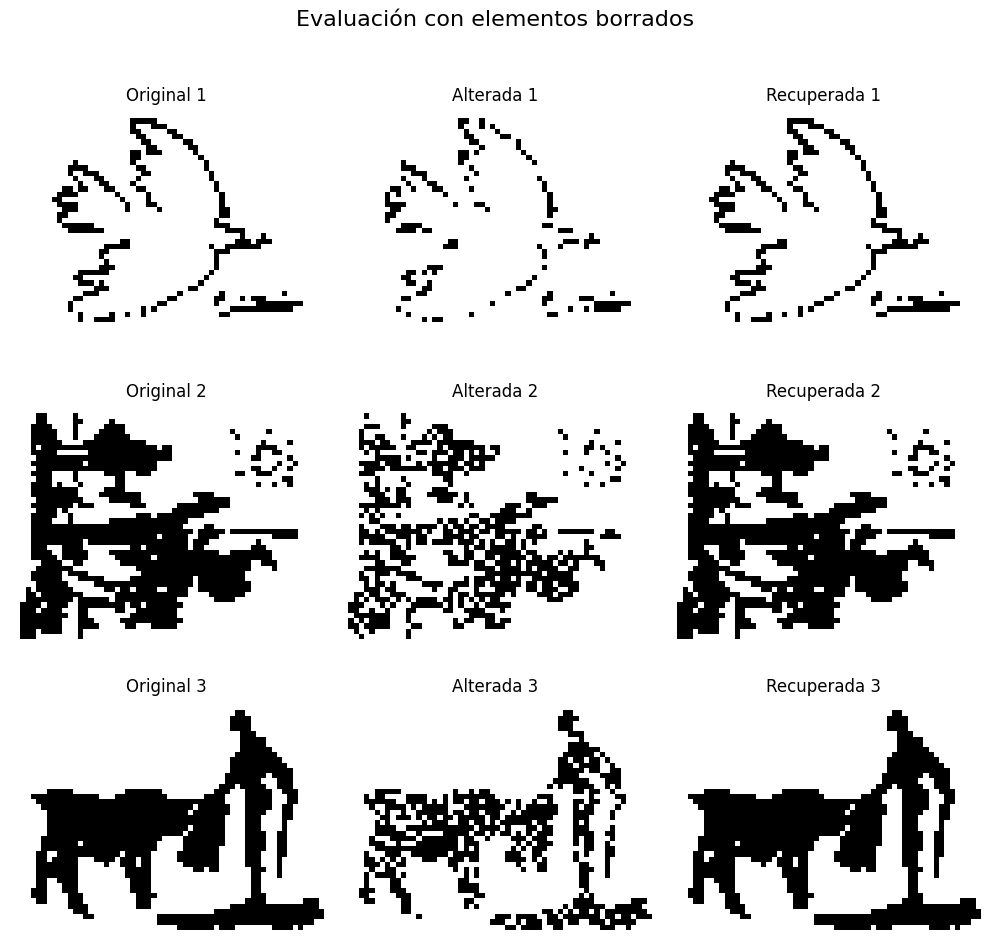

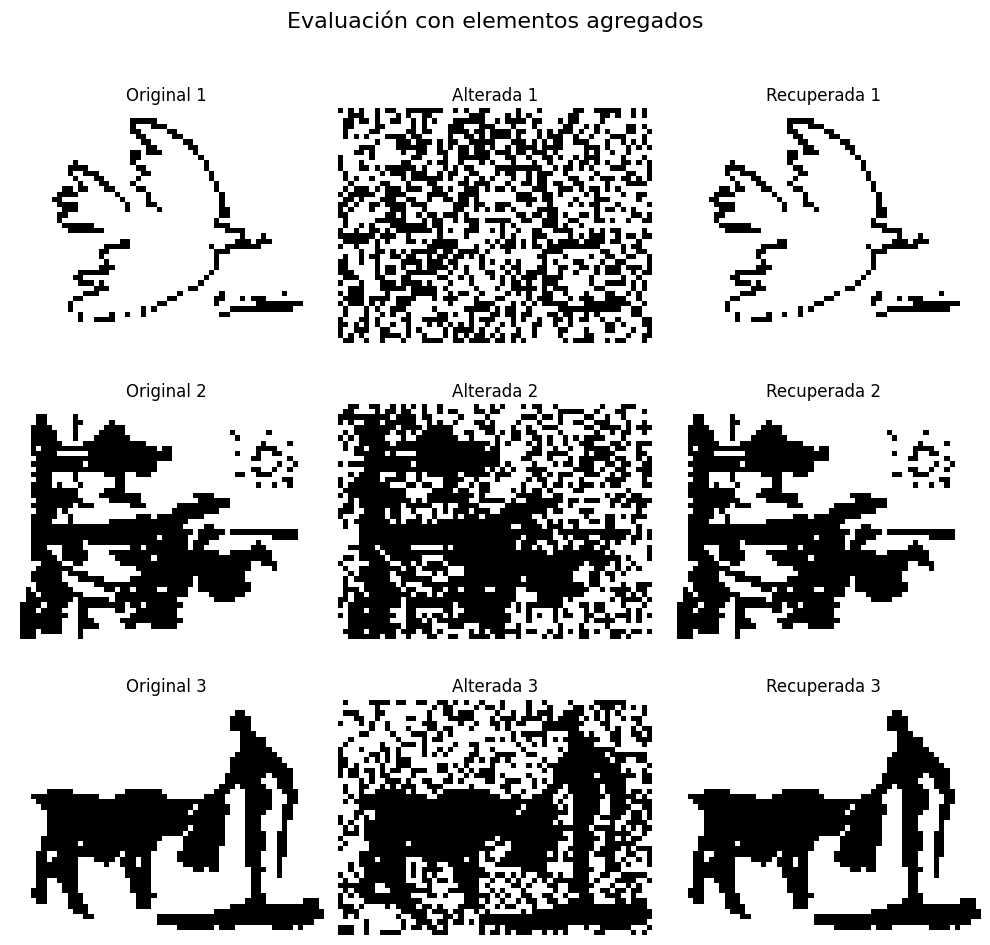

In [96]:
# VARIACIONES

# Agrega ruido 
def addNoise(pattern, noise_level=0.1):
    noisy_pattern = pattern.copy()
    num_noisy_elements = int(noise_level * len(pattern))
    noisy_indices = np.random.choice(len(pattern), num_noisy_elements, replace=False)
    noisy_pattern[noisy_indices] *= -1  # Invertir el estado de los elementos seleccionados

    return noisy_pattern

# Borra elementos (Blanco = 1)
def removeElements(pattern, removal_level=0.1):
    removed_pattern = pattern.copy()
    num_removed_elements = int(removal_level * len(pattern))
    removed_indices = np.random.choice(len(pattern), num_removed_elements, replace=False)
    for idx in removed_indices:
        if removed_pattern[idx] == -1:
            removed_pattern[idx] = 1

    return removed_pattern

# Agrega elementos (Negro = -1)
def addElements(pattern, addition_level=0.1):
    added_pattern = pattern.copy()
    num_added_elements = int(addition_level * len(pattern))
    added_indices = np.random.choice(len(pattern), num_added_elements, replace=False)
    for idx in added_indices:
        if added_pattern[idx] == 1:
            added_pattern[idx] = -1

    return added_pattern

# Evaluar la evolución de la red con versiones alteradas de las imágenes
def evaluateNetworkAlteredImages(weights, patterns, height, width, alteration_fn, alteration_level=0.1, sync=True, title="Evaluación"):
    # La alteracion se realiza con la funcion alteration_fn
    altered_patterns = [alteration_fn(pattern, alteration_level) for pattern in patterns]
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    row = 0

    for i, (original_pattern, altered_pattern) in enumerate(zip(patterns, altered_patterns)):
        original_image = patternToBMPImage(original_pattern, width, height)
        altered_image = patternToBMPImage(altered_pattern, width, height)
        input_pattern = altered_pattern.copy()
        
        if sync:
            hopfieldSync(weights, input_pattern, height, width, show=False)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title(f'Original {i+1}')
        axes[row, 0].axis('off')
        axes[row, 1].imshow(altered_image, cmap='gray')
        axes[row, 1].set_title(f'Alterada {i+1}')
        axes[row, 1].axis('off')
        axes[row, 2].imshow(recovered_image, cmap='gray')
        axes[row, 2].set_title(f'Recuperada {i+1}')
        axes[row, 2].axis('off')
        row = row + 1
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Titulos
title_noise = "Evaluación con ruido agregado"
title_removal = "Evaluación con elementos borrados"
title_addition = "Evaluación con elementos agregados"
# Parámetros de alteración
noise_level = 0.3
removal_level = 0.3
addition_level = 0.4

# Agregar ruido a las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addNoise, noise_level, sync, title_noise)
# Borrar elementos de las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, removeElements, removal_level, sync, title_removal)
# Agregar elementos a las imagenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addElements, addition_level, sync, title_addition)


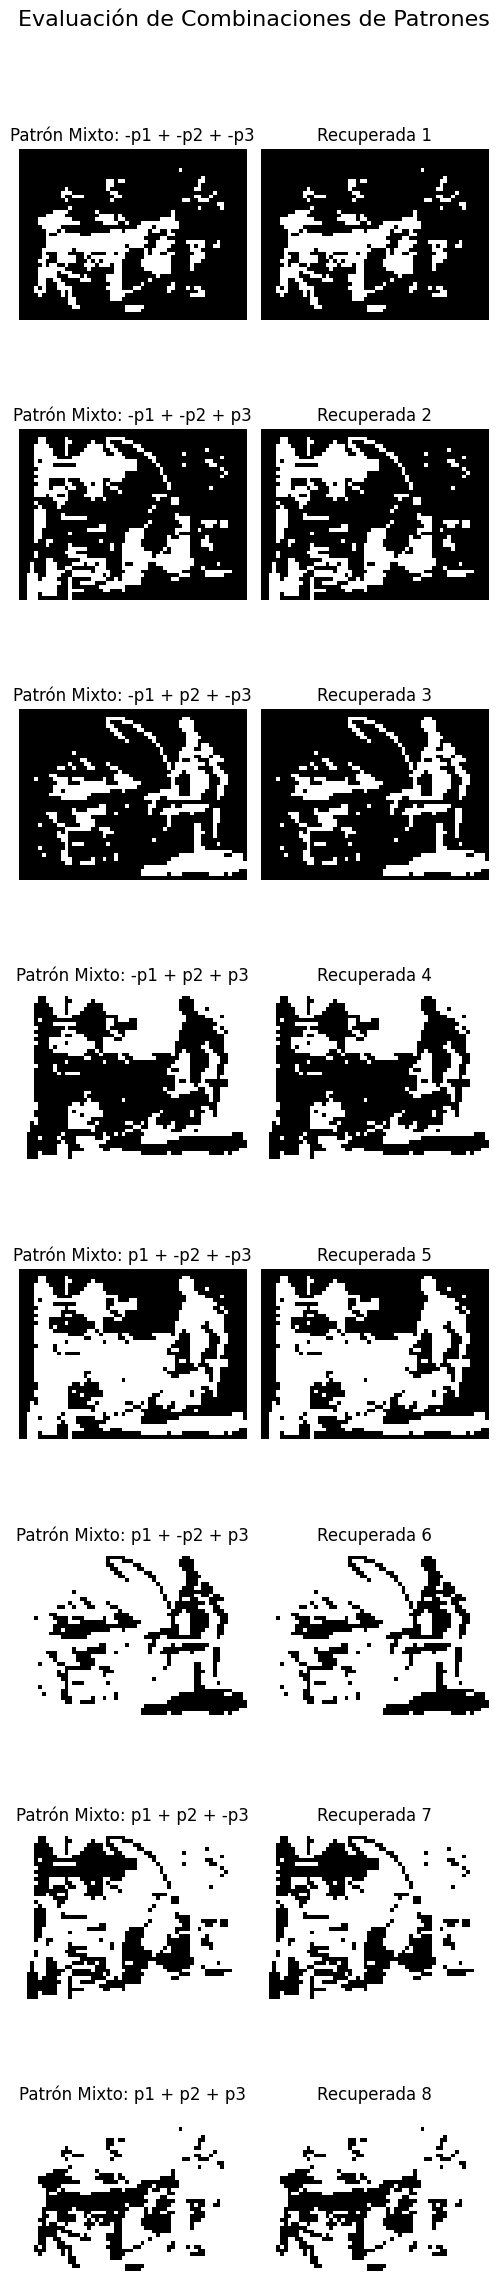

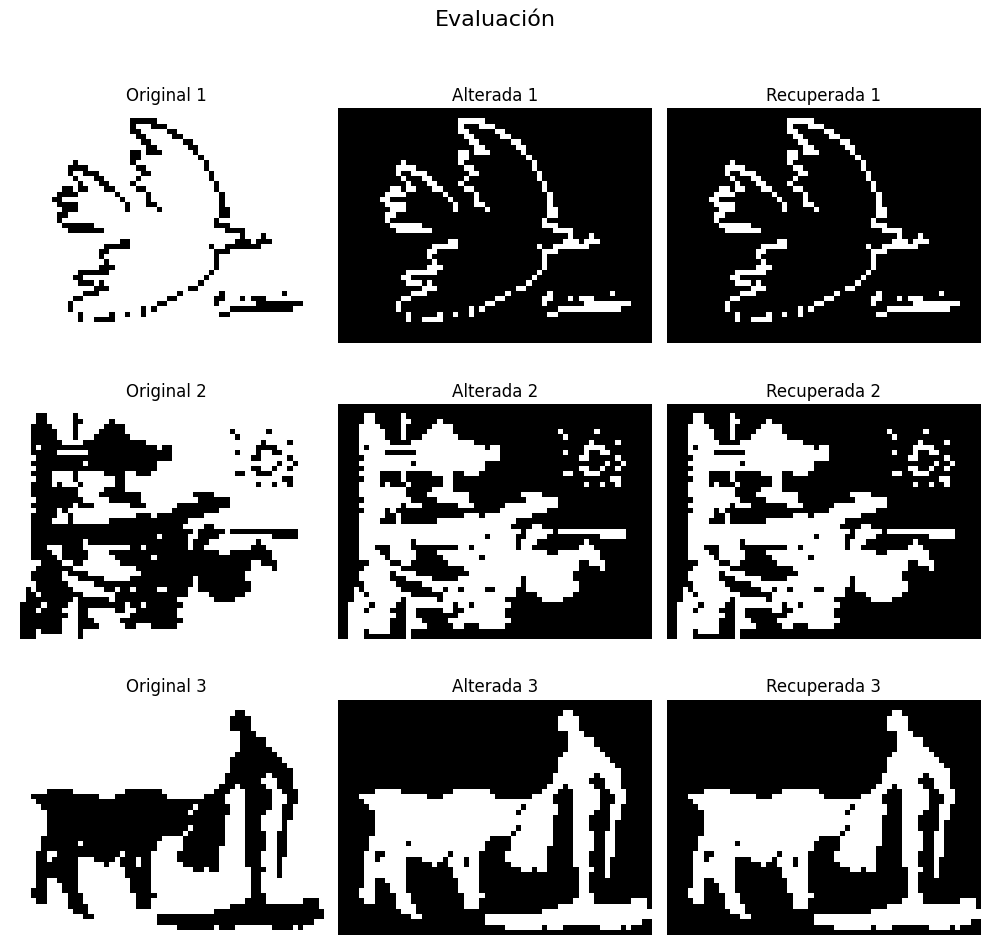

In [57]:
# Funciones para generar estados espurios

def generateInversePattern(pattern, alteration_level):
    """
    Genera el patrón inverso.
    """
    return -pattern

def generateMixturePattern(patterns):
    """
    Genera una combinación de un número impar de patrones.
    """
    combined_pattern = np.sign(np.sum(patterns, axis=0))
    return combined_pattern
from itertools import product

def generateAllMixturePatterns(patterns):
    """
    Genera todas las combinaciones posibles de un número impar de patrones
    utilizando sumas y restas.
    """
    num_patterns = len(patterns)
    all_combinations = []

    # Generar todas las combinaciones de signos para los patrones
    for signs in product([-1, 1], repeat=num_patterns):
        # Solo queremos combinaciones de un número impar de signos positivos
        if sum(signs) % 2 == 1:
            combined_pattern = np.sign(np.sum([sign * pattern for sign, pattern in zip(signs, patterns)], axis=0))
            all_combinations.append((signs, combined_pattern))

    return all_combinations

def evaluateAllMixturePatterns(weights, patterns, height, width, sync=True, title="Evaluación de Combinaciones de Patrones"):
    mixture_patterns = generateAllMixturePatterns(patterns)
    
    fig, axes = plt.subplots(len(mixture_patterns), 2, figsize=(5, 3 * len(mixture_patterns)))
    fig.suptitle(title, fontsize=16)

    for i, (signs, mixture_pattern) in enumerate(mixture_patterns):
        combination_detail = ' + '.join([f'{"-" if sign == -1 else ""}p{j+1}' for j, sign in enumerate(signs)])
        altered_image = patternToBMPImage(mixture_pattern, width, height)
        input_pattern = mixture_pattern.copy()
        
        if sync:
            hopfieldSync(weights, input_pattern, height, width, show=False)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[i, 0].imshow(altered_image, cmap='gray')
        axes[i, 0].set_title(f'Patrón Mixto: {combination_detail}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(recovered_image, cmap='gray')
        axes[i, 1].set_title(f'Recuperada {i+1}')
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()



# Variables para los títulos
title_inverse = "Evaluación de Patrones Inversos"
title_mixture = "Evaluación de Combinaciones de Patrones"

# Evaluar la red con combinaciones de patrones
evaluateAllMixturePatterns(weights, patterns, height, width, sync, title_mixture)

# Variables para los títulos
title_spurious = "Evaluación de Estados Espurios"

# Evaluar la red con estados espurios
#evaluateSpuriousStates(weights, patterns, height, width, sync, title_spurious)

# Variables para los títulos
title_inverse = "Evaluación de Estados Espurios - Patrones inversos"

# Evaluar la red con estados espurios
evaluateNetworkAlteredImages(weights, patterns, height, width, generateInversePattern, title_inverse)

In [7]:
# Rellena los bordes de negro para llegar hacer coincidir los tamaños
# ESTA FUNCION HAY QUE CAMBIARLA PARA QUE AGREGUE RUIDO BLANCO ASI NO HAY TANTA CORRELACION
def padImage(image, target_width, target_height):
    delta_width = target_width - image.width
    delta_height = target_height - image.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))

    return ImageOps.expand(image, padding, fill=0)

# Encuentra largo y ancho maximos y redimensiona las imagenes
def resizeImagesToCommonSize(images):
    max_width = max(image.width for image in images)
    max_height = max(image.height for image in images)
    
    resized_images = [padImage(image, max_width, max_height) for image in images]

    return resized_images, max_width, max_height

# Convierte imagen a patron
def imageToPattern(img):
    vector = np.array(img).astype(int)
    vector = vector.flatten()

    # Convertir los valores de 0 (negro) a -1 y 255 (blanco) a 1
    return 2 * vector - 1

images = list(images50x50) + list(images45x60)
# Redimensionar todas las imágenes a un tamaño común
resized_images, common_width, common_height = resizeImagesToCommonSize(images)
# Convertir las imágenes redimensionadas a patrones
patterns = [imageToPattern(image) for image in resized_images]
# Calcular la matriz de pesos utilizando la regla de Hebb
weights = computeWeights(patterns)

inputs = [pattern.copy() for pattern in patterns]
sync = True

for i, input in enumerate(inputs):
    print(f"Imagen original {i+1}:")
    display(resized_images[i])

    show = False
    updates = 0

    if sync:
        updates = hopfieldSync(weights, input, common_height, common_width, show)
        print("Porcentaje de error: ", 100*updates/(60*50))
    else:
        updates = hopfieldUnsync(weights, input, common_height, common_width, show)
    
    print(f"Imagen recuperada {i+1}:")
    recoveredImage = patternToBMPImage(input, common_width, common_height)
    display(recoveredImage)

    if updates == 0:
        print(f'La red aprendió la imagen {i+1} suministrada.')
        time.sleep(1)


NameError: name 'images50x50' is not defined

2.
a) Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la
cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño
de la red. Obtener experimentalmente los resultados de la siguiente tabla (los
valores de la tabla corresponden a una iteración con actualización sincrónica).
        Perror  pmax/N
        0,001   0,105
        0,0036  0,138
        0,01    0,185
        0,05    0,37
        0,1     0,61
(Tabla 2.1, sección 2.2, Hertz, Krogh & Palmer, pág. 19)
b) Analice cómo cambia la capacidad de una red en función de la correlación entre 
patrones

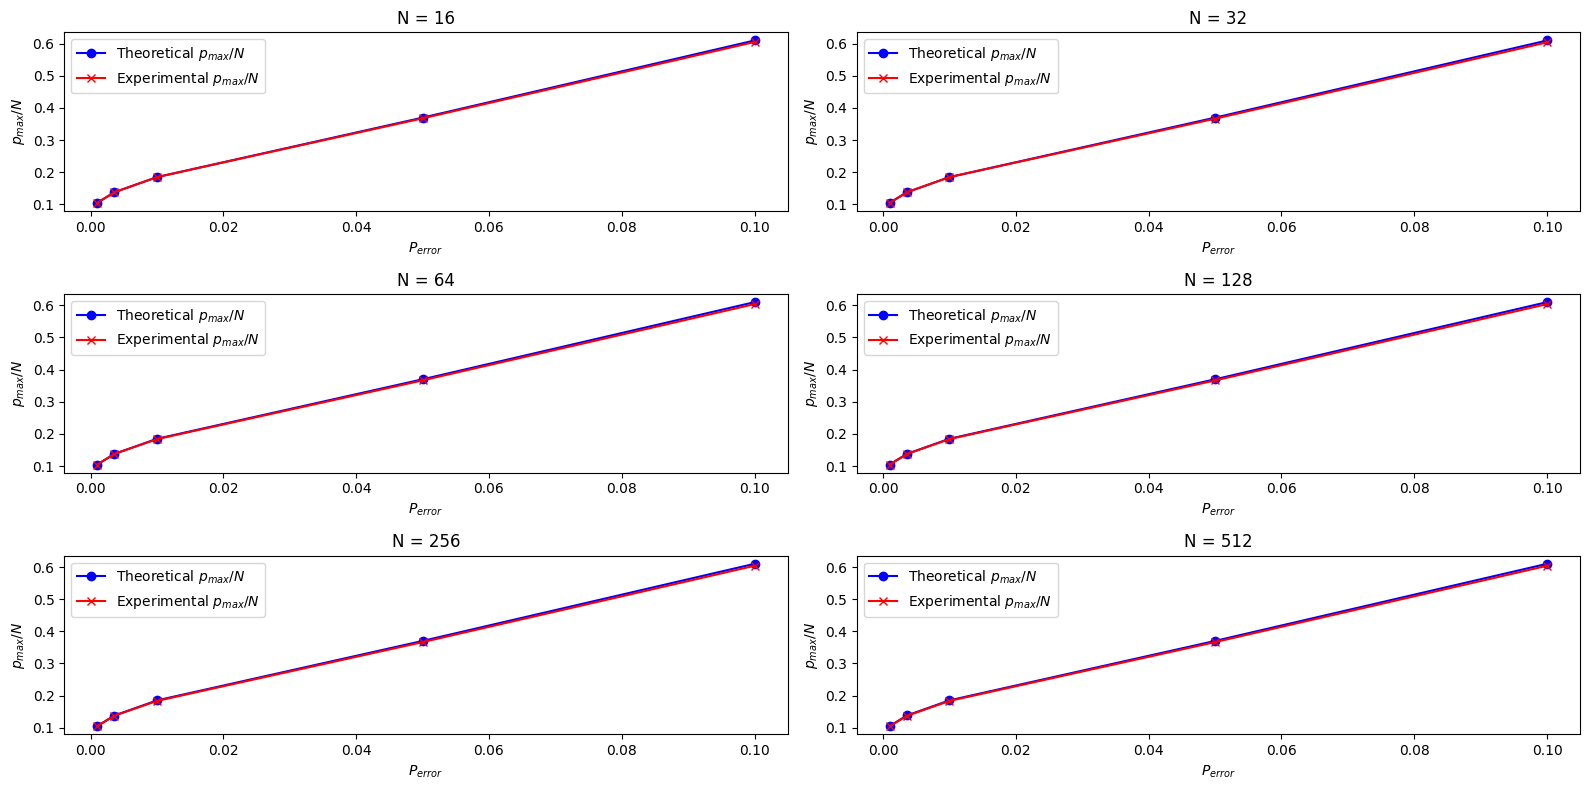

In [4]:
# Values from the table
P_error = np.array([0.001, 0.0036, 0.01, 0.05, 0.1])
p_max_N = np.array([0.105, 0.138, 0.185, 0.37, 0.61])

# Function to perform the simulation
def simulateHopfieldNetwork(N, P_error, p_max_N):
    p_max_theoretical = p_max_N
    p_max_experimental = []

    for p_theoretical in p_max_theoretical:
        num_patterns = int(p_theoretical * N)
        errors = 0

        # Generate random patterns
        random_patterns = np.random.choice([-1, 1], size=(num_patterns, N))
        
        # Initialize the weights matrix
        W = computeWeights(random_patterns)
        
        # Test pattern retrieval
        correct_retrievals = 0

        for pattern in random_patterns:
            input_pattern = np.copy(pattern)
            hopfieldSync(W, input_pattern)  # No visualization
            if np.array_equal(input_pattern, pattern):
                correct_retrievals += 1
        
        errors += (num_patterns - correct_retrievals) / num_patterns

        p_max_experimental.append(p_theoretical * (1 - errors / 100))
    
    return p_max_experimental

# Network sizes
N_values = [16, 32, 64, 128, 256, 512]

# Create the plot
fig, axs = plt.subplots(3, 2, figsize=(16, 8))
axs = axs.flatten()

for i, N in enumerate(N_values):
    p_max_experimental = simulateHopfieldNetwork(N, P_error, p_max_N)
    
    axs[i].plot(P_error, p_max_N, 'o-', color='blue', label='Theoretical $p_{max}/N$')
    axs[i].plot(P_error, p_max_experimental, 'x-', color='red', label='Experimental $p_{max}/N$')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('$P_{error}$')
    axs[i].set_ylabel('$p_{max}/N$')
    axs[i].legend()

plt.tight_layout()
plt.show()

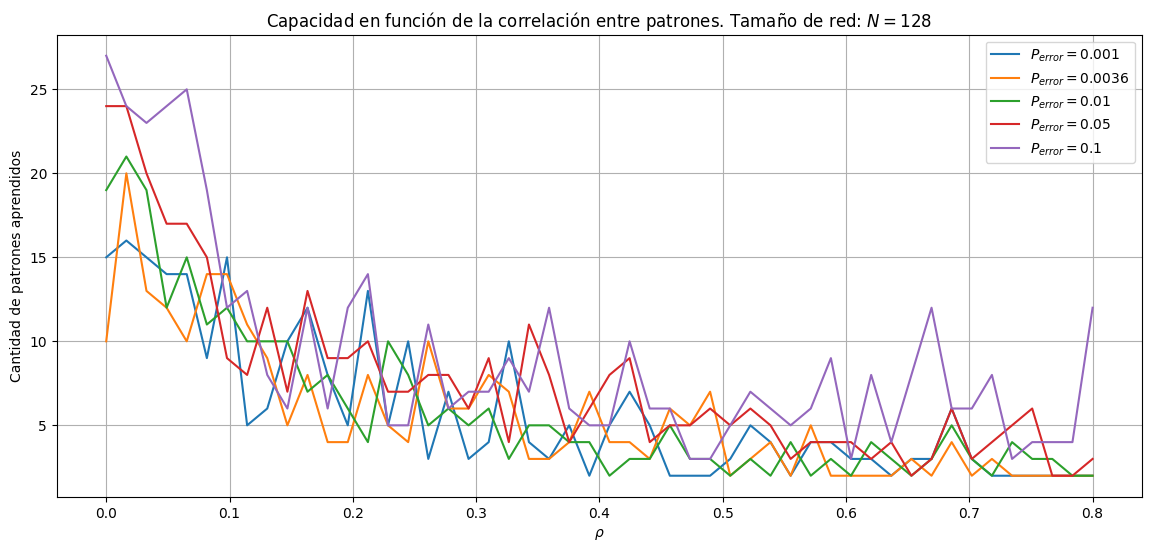

In [4]:

# Parameters
N = 128  # Size of the network
P_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
correlation_levels = np.linspace(0, 0.8, 50)  # Correlation levels from 0 to 0.8 pasos de a 0.02 
rho_min = 0
rho_max = 0.8
mean = np.zeros(N)
#Similitud promedio: rho

# Gráfico de la capacidad en función de la correlación entre patrones
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.set_title(f'Capacidad en función de la correlación entre patrones. Tamaño de red: $N = {N}$')

for p_error in P_errors:
    #print("P_error: ", p_error)
    p_max_experimental = []

    for rho in correlation_levels:
        #print("Rho: ", rho)
        correlated_patterns = []
        cov_matrix = np.ones((N, N)) * rho
        np.fill_diagonal(cov_matrix, 1)
        learning = True

        while learning:
            correlated_vector = np.random.multivariate_normal(mean, cov_matrix, 1)
            correlated_pattern = np.where(correlated_vector >= 0, 1, -1)[0]
            correlated_patterns.append(correlated_pattern)
            W = computeWeights(correlated_patterns)
            bad_bits = 0
            learned_patterns = 0

            for pattern in correlated_patterns:
                input_pattern = pattern.copy()
                hopfieldSync(W, input_pattern)
                bad_bits += np.sum(input_pattern != pattern)
                learned_patterns += 1

            P_e = float(bad_bits / (len(correlated_patterns) * N))
            if P_e > p_error:
                p_max_experimental.append(len(correlated_patterns) - 1)
                #print("Error: ", P_e, "\nAprendidos: ", len(correlated_patterns))
                learning = False

    ax.plot(correlation_levels, p_max_experimental, label=f'$P_{{error}} = {p_error}$')

ax.set_xlabel("$\\rho$")
ax.set_ylabel('Cantidad de patrones aprendidos')
ax.legend()
ax.grid()

plt.show()


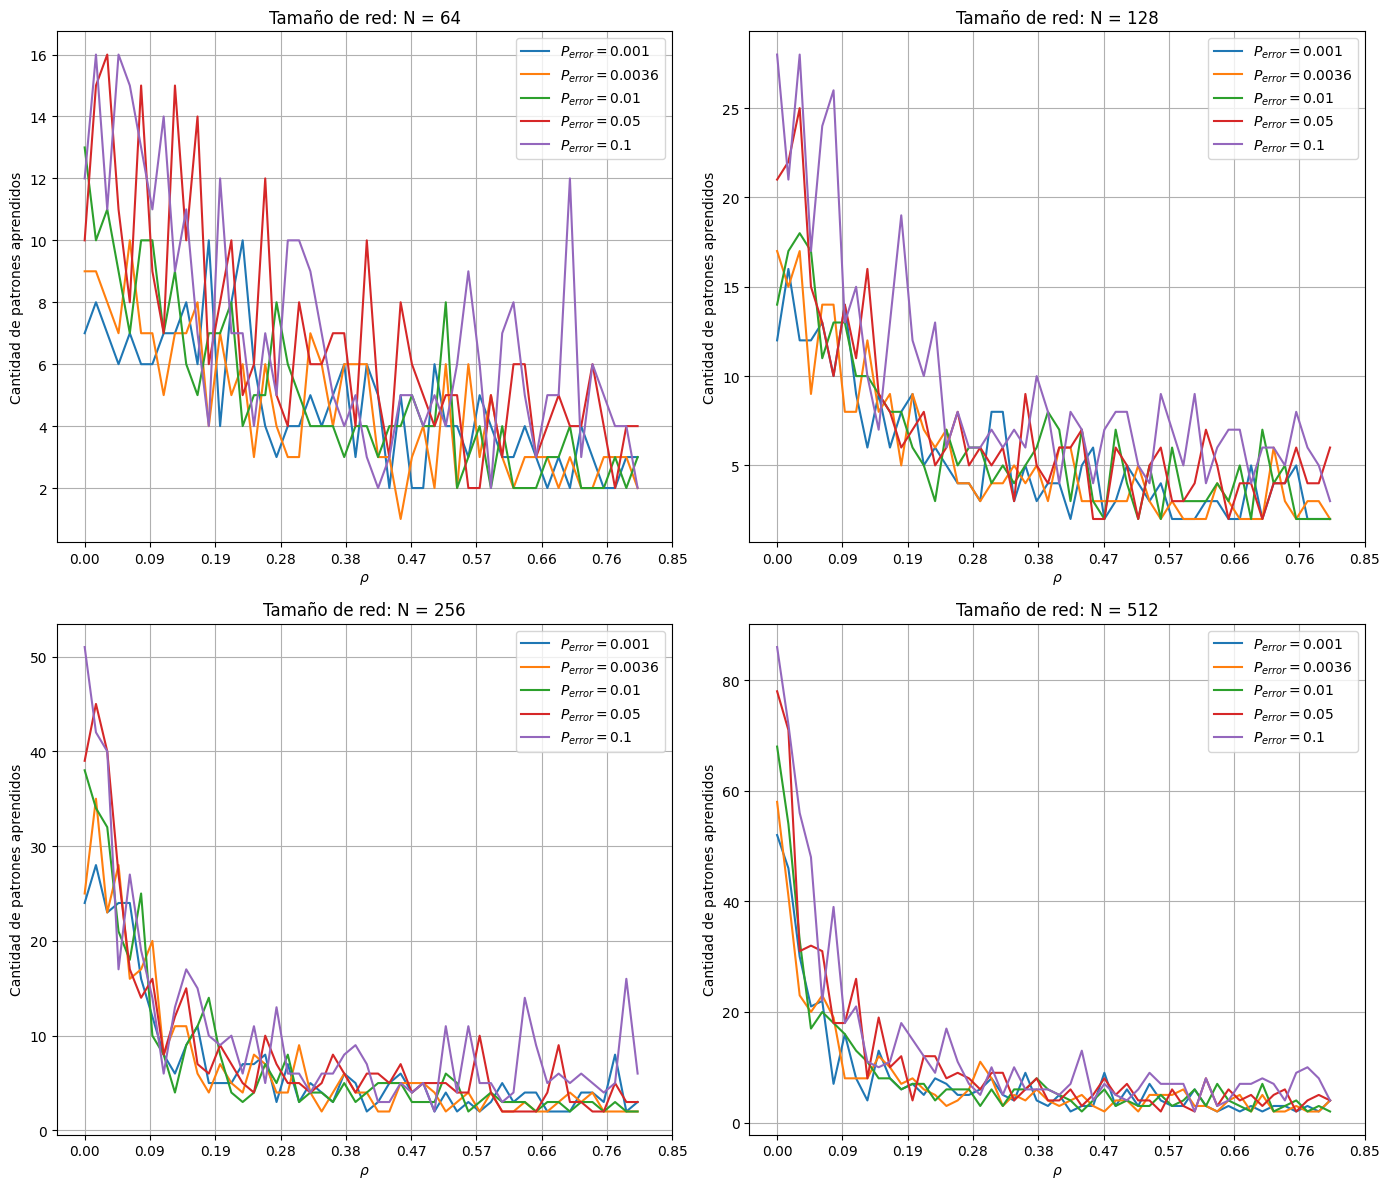

In [6]:
# Tamaños de la red a evaluar
N_values = [64, 128, 256, 512]
P_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
rho_min = 0
rho_max = 0.8
correlation_levels = np.linspace(rho_min, rho_max, 50)
mean = np.zeros(N_values[0])

# Gráfico de la capacidad en función de la correlación entre patrones
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, N in enumerate(N_values):
    mean = np.zeros(N)
    for p_error in P_errors:
        p_max_experimental = []

        for rho in correlation_levels:
            correlated_patterns = []
            cov_matrix = np.ones((N, N)) * rho
            np.fill_diagonal(cov_matrix, 1)
            learning = True

            while learning:
                correlated_vector = np.random.multivariate_normal(mean, cov_matrix, 1)
                correlated_pattern = np.where(correlated_vector >= 0, 1, -1)[0]
                correlated_patterns.append(correlated_pattern)
                W = computeWeights(correlated_patterns)
                bad_bits = 0
                learned_patterns = 0

                for pattern in correlated_patterns:
                    input_pattern = pattern.copy()
                    hopfieldSync(W, input_pattern)
                    bad_bits += np.sum(input_pattern != pattern)
                    learned_patterns += 1

                P_e = float(bad_bits / (len(correlated_patterns) * N))
                if P_e > p_error:
                    p_max_experimental.append(len(correlated_patterns) - 1)
                    learning = False

        axs[i].plot(correlation_levels, p_max_experimental, label=f'$P_{{error}} = {p_error}$')
    axs[i].set_title(f'Tamaño de red: N = {N}')
    axs[i].set_xlabel("$\\rho$")
    axs[i].set_ylabel('Cantidad de patrones aprendidos')
    xticks = np.linspace(rho_min, rho_max + 0.05, 10)
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels([f'{xtick:.2f}' for xtick in xticks])
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()


3. Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie
qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas
al azar.
a) ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?
b) ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

In [22]:
# Tamaño de la red
N = 248  # Puedes ajustar el tamaño de la red según sea necesario

# Número de patrones pseudo-aleatorios
num_patterns = 10

# Función para generar patrones pseudo-aleatorios
def generatePatterns(N, num_patterns):
    return np.random.choice([-1, 1], size=(num_patterns, N))

# Función para eliminar sinapsis al azar
def removeSynapses(weights, percentage, N):
    N = len(weights)
    total_synapses = N * (N - 1)
    num_synapses_to_remove = int(total_synapses * percentage / 100)
    
    for _ in range(num_synapses_to_remove):
        i, j = np.random.randint(0, N, 2)
        while i == j:  # Asegurar que no eliminamos autoconexiones
            i, j = np.random.randint(0, N, 2)
        weights[i, j] = 0
        weights[j, i] = 0
    return weights

# Generar patrones pseudo-aleatorios
patterns = generatePatterns(N, num_patterns)

# Calcular la matriz de pesos
weights = computeWeights(patterns)

# Porcentajes de sinapsis a eliminar
percentages = np.linspace(0, 100, 41)  # De 0% a 100% en pasos de 5%

# Evaluar el error en función del porcentaje de sinapsis eliminadas
errors = []

for percentage in percentages:
    weights_modified = removeSynapses(weights.copy(), percentage)
    total_bad_bits = 0

    for pattern in patterns:
        input_pattern = pattern.copy()
        hopfieldSync(weights_modified, input_pattern)
        total_bad_bits += np.sum(input_pattern != pattern)

    P_error = total_bad_bits / (num_patterns * N)
    errors.append(P_error)

# Graficar el error en función del porcentaje de sinapsis eliminadas
plt.plot(percentages, errors, 'x-')
plt.xlabel('Porcentaje de sinapsis eliminadas (%)')
plt.ylabel('Error')
plt.title('Error en función del porcentaje de sinapsis eliminadas')
plt.grid(True)
plt.show()


TypeError: removeSynapses() missing 1 required positional argument: 'N'

SUMA EN UN EJE:  -0.75
SUMA EN OTRO EJE:  [ 0.      0.     -0.125   0.0625  0.125  -0.0625  0.     -0.0625  0.
 -0.3125 -0.125  -0.0625 -0.125   0.0625  0.     -0.0625  0.      0.1875
  0.0625  0.     -0.0625  0.0625  0.      0.1875  0.      0.      0.0625
 -0.125  -0.375  -0.125   0.125  -0.0625]
SUMA EN UN EJE:  0.0
SUMA EN OTRO EJE:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
SUMA EN UN EJE:  1.0
SUMA EN OTRO EJE:  [ 0.0625  0.125   0.      0.5     0.      0.      0.      0.125  -0.25
  0.0625  0.      0.     -0.125   0.      0.3125  0.0625  0.     -0.125
 -0.1875  0.      0.125  -0.125   0.      0.0625 -0.125   0.0625  0.1875
  0.      0.1875 -0.125   0.      0.1875]
SUMA EN UN EJE:  0.0
SUMA EN OTRO EJE:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
SUMA EN UN EJE:  -0.75
SUMA EN OTRO EJE:  [ 0.0625  0.      0.1875 -0.25    0.125   0.      0.0625  0.      0.
 -0.25    0.  

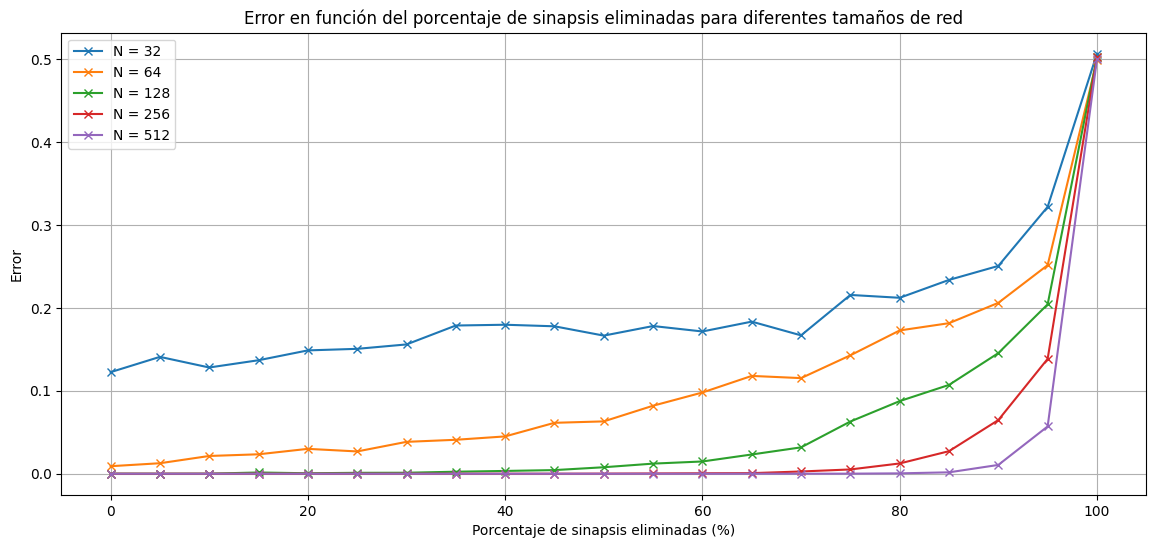

In [62]:
# Función para generar patrones pseudo-aleatorios
def generatePatterns(N, num_patterns):
    return np.random.choice([-1, 1], size=(num_patterns, N))

# Función para eliminar sinapsis al azar
def removeSynapses(weights, percentage, N):
    total_synapses = N * (N - 1)
    num_synapses_to_remove = int(total_synapses * percentage / 200)
    removed_synapses = set()
    for diagonal_i in range(N):
        removed_synapses.add((diagonal_i, diagonal_i))
    
    for _ in range(num_synapses_to_remove):
        i, j = np.random.randint(0, N, 2)
        while (i, j) in removed_synapses or (j, i) in removed_synapses:
            i, j = np.random.randint(0, N, 2) 
        #if (i, j) not in removed_synapses and (j, i) not in removed_synapses:
        weights[i, j] = 0.
        weights[j, i] = 0.
        removed_synapses.add((i, j))
    
    return weights

# Tamaños de la red a evaluar
Ns = [32, 64, 128, 256, 512]
# Número de patrones pseudo-aleatorios
num_patterns = 10
# Porcentajes de sinapsis a eliminar
percentages = np.linspace(0, 100, 21)  # De 0% a 100% en pasos de 2.5%
# Número de experimentos
num_experiments = 10

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

for N in Ns:
    all_errors = []
    
    for _ in range(num_experiments):
        patterns = generatePatterns(N, num_patterns)
        weights = computeWeights(patterns)
        #print(weights)
        errors = []

        for percentage in percentages:
            #print("Porcentaje de borrado: ", percentage)
            weights_modified = removeSynapses(weights.copy(), percentage, N)
            #print(weights_modified)
            total_bad_bits = 0

            for pattern in patterns:
                input_pattern = pattern.copy()
                hopfieldSync(weights_modified, input_pattern)
                total_bad_bits += np.sum(input_pattern != pattern)

            P_error = total_bad_bits / (num_patterns * N)
            errors.append(P_error)
        
        all_errors.append(errors)

    mean_errors = np.mean(all_errors, axis=0)
    ax.plot(percentages, mean_errors, 'x-', label=f'N = {N}')

ax.set_xlabel('Porcentaje de sinapsis eliminadas (%)')
ax.set_ylabel('Error')
ax.set_title('Error en función del porcentaje de sinapsis eliminadas para diferentes tamaños de red')
ax.grid(True)
ax.legend()
plt.show()
